In [17]:
import os
os.chdir("/Users/mphomafata/Documents/GitHub/Chromatographic-data")
import pandas as pd
from scipy.io import netcdf_file
beer_files = sorted(os.listdir("/Users/mphomafata/Documents/Work_file/Collaborative Work/Cody/Untargeted - Gin and Beer/raw_data/Beer/"))
beer_data = []
for beer_file in beer_files[:1]:
    cdf_file = netcdf_file(f'/Users/mphomafata/Documents/Work_file/Collaborative Work/Cody/Untargeted - Gin and Beer/raw_data/Beer/{beer_file}', mmap=False)
    data = pd.DataFrame(columns=["retention_time","mass_values", "intensities"])
    # variables of interest
    mass_values = cdf_file.variables['mass_values'].data
    retention_time = cdf_file.variables['scan_acquisition_time'].data
    point_count = cdf_file.variables['point_count'].data
    
    # cumulative counter 
    def Cumulative(lists): 
        cu_list = [] 
        length = len(lists) 
        cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)] 
        return cu_list[1:]
    lists = point_count
    point_counter = Cumulative(lists)
    
    for i, s in enumerate(retention_time):
        if i==0:
            start = i
        else:
            start = point_counter[i-1]+1
        stop = point_counter[i]
        rt = cdf_file.variables['scan_acquisition_time'][i]
        # print("retention time " + str(rt)+ " has " + str(point_count[i]) + " points starting at " + str(start) + " ending at " + str(stop))
        intensities = cdf_file.variables['intensity_values'][start:stop]
        mass_values = cdf_file.variables['mass_values'][start:stop]
        data.loc[len(data.index)] = [rt,mass_values, intensities]
    data = data.explode(['mass_values','intensities']).reset_index(drop=True)
    # data = data.explode('intensities')
    beer_data.append(data)
    # data.to_excel(f"{beer_file}.xlsx") # too large  to print to excel
    print("Finished sample " + str(beer_files.index(f"{beer_file}") +1) + " of " + str(len(beer_files)))
    # print(f"Sample {beer_file} completed!")
cdf_file .close()


Finished sample 1 of 95


# Plot the 2D and 3D spectrum for the first sample
# 2D Plot


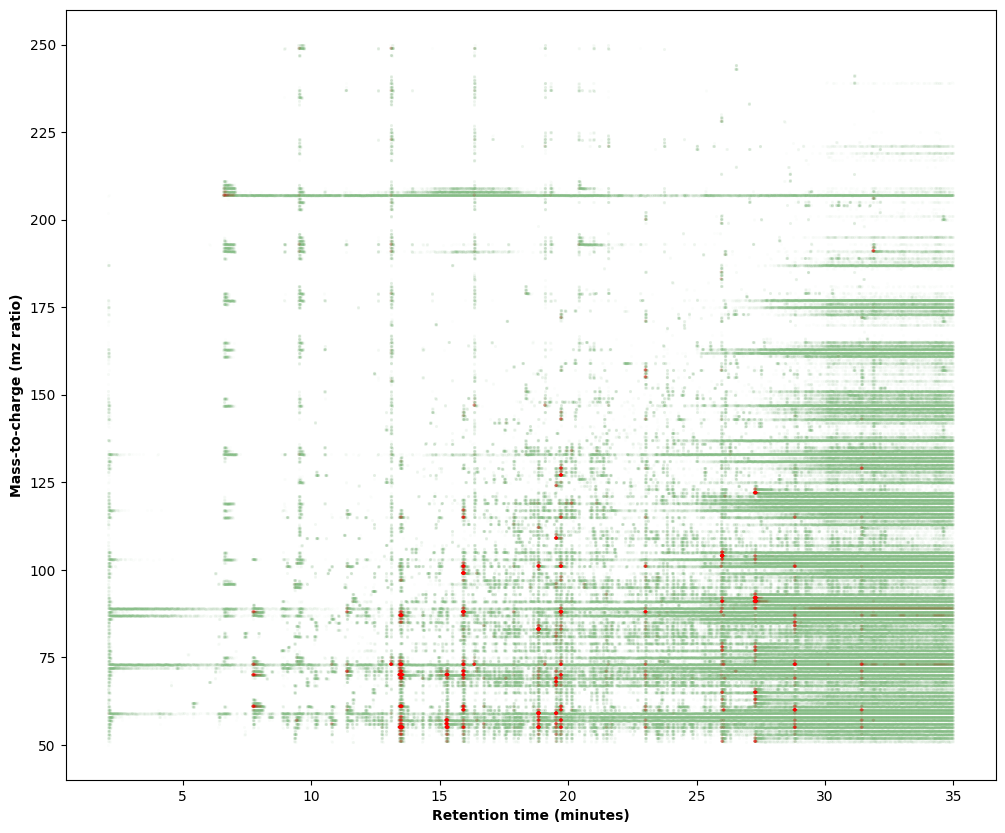

In [19]:
import matplotlib.pyplot as plt
data = beer_data[0]
x = data["retention_time"]/60
y = data["mass_values"]
z = data["intensities"]

# Creating figure
fig= plt.figure(figsize = (12, 10))
 
# Creating plot
plt.scatter(x, y, 
             c = 'green', 
             marker = "x", s= 2, alpha = 0.01)
plt.scatter(x, y,
            c = 'red', 
             marker = "x", s= 2, alpha = z/(max(z)))
plt.xlabel('Retention time (minutes)', fontweight ='bold') 
plt.ylabel('Mass-to-charge (mz ratio)', fontweight ='bold') 
plt.savefig(fname = "2d_plot.jpg",dpi = 600,
                        transparent=True, format = "jpg")
plt.show()

# 3D Plot

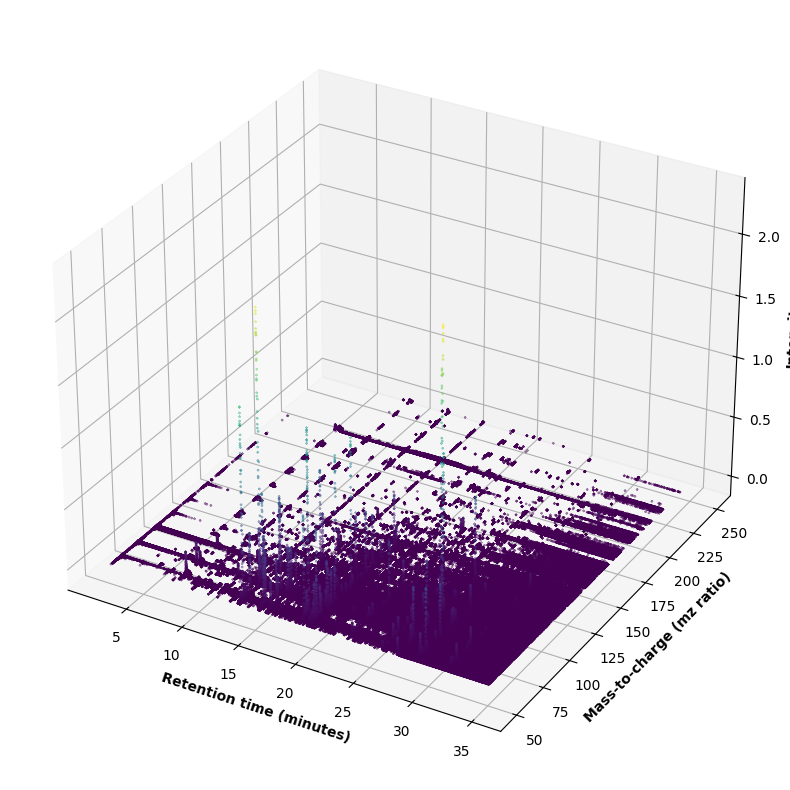

In [34]:
import matplotlib.pyplot as plt
data = beer_data[0]

# Creating figure
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=data["retention_time"]/60,
           ys = data["mass_values"], 
           zs = data["intensities"], 
           c = data["intensities"]
           ,
           marker = "x", s= 1, alpha = 0.5)

ax.set_xlabel('Retention time (minutes)', fontweight ='bold') 
ax.set_ylabel('Mass-to-charge (mz ratio)', fontweight ='bold') 
ax.set_zlabel('Intensity', fontweight ='bold')
plt.savefig(fname = "3d_plot.jpg",dpi = 300,
                        transparent=True, format = "jpg")
plt.show()

# CREATE A MERGED DATAFRAME OF THE CHROMATOGRAMS

In [ ]:
import pandas as pd

beer_data[0]["retention_time"] = round(beer_data[0]["retention_time"])
beer_data[0]["mass_values"] = round(beer_data[0]["mass_values"],2)
beer_data[0].rename(columns = {"intensities": f"{beer_files[0]}"}, inplace=True)
beer_data[1]["retention_time"] = round(beer_data[1]["retention_time"])
beer_data[1]["mass_values"] = round(beer_data[1]["mass_values"],2)
beer_data[1].rename(columns = {"intensities": f"{beer_files[1]}"}, inplace=True)

dataset = pd.merge(left = beer_data[0], right = beer_data[1], on = ["retention_time", "mass_values"], how = "outer")

for i in range(2,len(beer_data)):
    beer_data[i]["retention_time"] = round(beer_data[i]["retention_time"])
    beer_data[i]["mass_values"] = round(beer_data[i]["mass_values"],2)
    beer_data[i].rename(columns = {"intensities": f"{beer_files[i]}"}, inplace=True)
    dataset = pd.merge(left = dataset, right = beer_data[i], on = ["retention_time", "mass_values"], how = "outer")
print(dataset)

# MULTIVARIATE ANALYSIS

In [ ]:
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from adjustText import adjust_text

my_data = dataset
my_data["sample_code"] = my_data["retention_time"].astype("string") + "_" + my_data["mass_values"].astype("string")
my_data.set_index("sample_code", inplace=True) # set the feature_code to index
# my_data.drop(columns=my_data.columns[2:], inplace=True) # remove the retention_time and mass-to-charge columns
my_data = my_data.transpose()
my_data = my_data[2::]
features = my_data.columns
my_data["sample_code"] = my_data.index
df = my_data.fillna(0)

# Separating out the features
x = df.loc[:, features].values

# Separating out the target
y = df.loc[:,["sample_code"]].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# get component projections
pca = PCA(n_components=2 ) #len(df)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
finalDf = pd.concat([principalDf, df[["sample_code"]]], axis = 1)

# VISUALISE
plt.figure(figsize = (20,15))
plt.xlabel(('PC1 (' + str(round(((pca.explained_variance_ratio_)[0]*100),2))+"%)" ), fontsize = 12, loc="center")
plt.ylabel(('PC2 ('+ str(round(((pca.explained_variance_ratio_)[1]*100),2))+"%)" ), fontsize = 12, loc="center")
plt.axhline(0, color='black', linestyle = "-.", linewidth = 1)
plt.axvline(0, color='black', linestyle = "-.", linewidth = 1)

# SCORES
labels = df[["sample_code"]]

plt.scatter(finalDf[0],finalDf[1], c= "green", marker="D", s= 200, alpha=0.5)
scores_labels = []
for i in range(0, len(labels)):
    scores_labels.append(plt.text(finalDf[0].iloc[i],
            finalDf[1].iloc[i],
             f'{labels[i]}',
             fontsize=10,
             horizontalalignment="center",
             verticalalignment='center')
    )
# adjust_text(scores_labels, only_move={'points':'x', 'texts':'x'}, arrowprops=dict(arrowstyle="->", color='grey', lw=0.8))

# SAVE THE GRAPH
plt.savefig(fname='PCA_concat.jpg', dpi=600, bbox_inches=None,transparent=True, format="jpg")


# LOADINGS

In [ ]:

loadings = pd.DataFrame((pca.components_.T * (pca.explained_variance_)), index=features)

# LOADINGS
plt.scatter(loadings[0], loadings[1], marker="v", c="red")
loadings_labels = []
for i in range(0, len(features)):
   loadings_labels.append(
   plt.text(loadings[0].iloc[i],
            loadings[1].iloc[i],
             f'{features[i]}',
             fontsize=10,
             horizontalalignment="center",
             verticalalignment='bottom',
             # bbox=dict(facecolor='grey', alpha=0.2),
             # style='italic'
             )
   )
# adjust_text(loadings_labels, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='grey', lw=0.8))
plt.show()